<a href="https://colab.research.google.com/github/Soyoung-n/prac_class/blob/main/class9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting house prices

분석 목적 : 1970년대 중반 보스턴 교외의 집값의 중위값 예측

특이사항 : few data points/ each feature in the input data has a different scale

1. Load the data

In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets)= boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

2. Prepare the data

widly different ranges -> makes nn learning more difficult

A widespread practice to deal with these problems is to do feautre-wise normalization

: subtract the mean of the feature and divide by the s.d

In [23]:
mean= train_data.mean(axis=0)
std= train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

3. Build network

The less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
  model= models.Sequential()
  model.add(layers.Dense(64, activation='relu', 
                         input_shape= (train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [31]:
import numpy as np

k= 4
num_val_samples= len(train_data)// k
num_epochs= 100
all_scores= []

for i in range(k) :
  print('processing fold #', i)
  val_data= train_data[i*num_val_samples :(i+1)* num_val_samples]
  val_targets= train_targets[i*num_val_samples: (i+1)*num_val_samples]

  partial_train_data= np.concatenate(
      [train_data[: i*num_val_samples],
       train_data[(i+1)*num_val_samples:]], 
       axis=0)
  partial_train_targets= np.concatenate(
      [train_data[: i*num_val_samples],
       train_data[(i+1)*num_val_samples:]], 
       axis=0)
  
  model= build_model()
  model.fit(partial_train_data, partial_train_targets, epochs= num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae= model.evaluate(val_data, val_targets, verbose= 0) #verbose=0 : do not show the processing bar
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [29]:
all_scores

[21.83490562438965, 22.04509925842285, 21.376096725463867, 24.296886444091797]

In [9]:
np.mean(all_scores)

22.393342971801758

When we want to find the best num_epochs, we need to save all history of mae

In [ ]:
from tensorflow.keras import backend as K

#some memory clean-up
K.clear_session()

In [13]:
num_epochs= 500
all_mae_histories= []

for i in range(k) :
  print('processing fold #', i)
  val_data= train_data[i*num_val_samples :(i+1)* num_val_samples]
  val_targets= train_targets[i*num_val_samples: (i+1)*num_val_samples]

  partial_train_data= np.concatenate(
      [train_data[: i*num_val_samples],
       train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_targets= np.concatenate(
      [train_data[: i*num_val_samples],
       train_data[(i+1)*num_val_samples:]], axis=0)
  
  model= build_model()
  history= model.fit(partial_train_data, partial_train_targets, 
                     validation_data= (val_data, val_targets),
                     epochs= num_epochs, batch_size=1, verbose=0)
  mae_history= history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [22]:
average_mae_history= [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

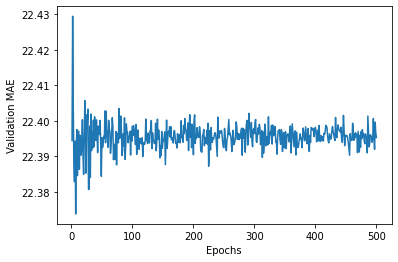

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()